# Cut Implementations

By default I was using the error function, but I stumbled across some other implementations. This chapter explores some of the options.

Note: This will write out a file called `jax_cuts.py` which contains the source code so that the code can be used in other places.

In [1]:
# This cell magic will both run the cell, and also emit it to an output file.
from util_nb import write_and_run

In [2]:
%%write_and_run jax_cuts.py
import jax.numpy as jnp
import jax
from typing import Callable

In [3]:
import matplotlib.pyplot as plt
from jax_helpers import data_sig_j, data_back_j
from typing import Dict
import functools as ft
import tabulate
import numpy as np

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Error Function

This was where I started. Lets develop a few tools here we can use later on to define the error function.

In [4]:
%%write_and_run -a jax_cuts.py


def cut_erf(cut: float, data):
    "Take a jax array and calculate an error function on it"
    return (jax.lax.erf(data - cut) + 1) / 2.0


def loss_sig_sqrt_b(f, sig_j, back_j):
    "Calculate the S/sqrt(B) for two 1D numpy arrays with the cut at cut."

    # Weight the data and then do the sum
    wts_sig = f(sig_j)
    wts_back = f(back_j)

    S = jnp.sum(wts_sig)
    B = jnp.sum(wts_back)

    return S / jnp.sqrt(B)

Setup some setup to plot the function and its grad - that we can re-use below.

Start with the function itself - or its average weight.

In [5]:
data_max = max(max(data_sig_j), max(data_back_j))
data_min = min(min(data_sig_j), min(data_back_j))
lower_limit = data_min - (abs(data_min) * 0.2)
upper_limit = data_max + (abs(data_max) * 0.2)

In [6]:
x_values = np.linspace(lower_limit, upper_limit, 100)

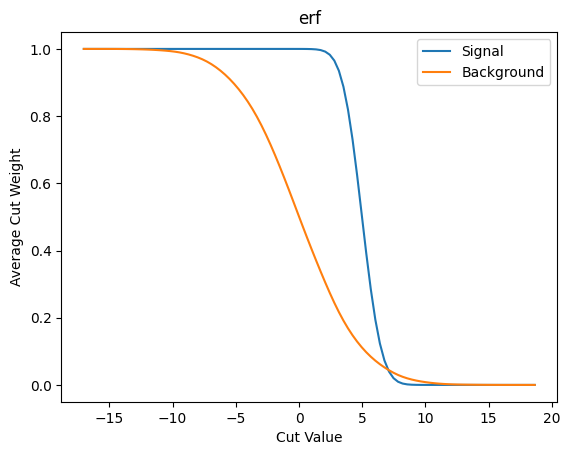

In [7]:
def plot_avg_weight(f: Callable, name: str):
    plt.plot(x_values, np.array([jnp.average(f(c, data_sig_j)) for c in x_values]), label='Signal')
    plt.plot(x_values, np.array([jnp.average(f(c, data_back_j)) for c in x_values]), label='Background')
    plt.xlabel('Cut Value')
    plt.ylabel('Average Cut Weight')
    plt.title(name)
    plt.legend()
    plt.show()

plot_avg_weight(cut_erf, 'erf')

Next lets look at the $S/\sqrt{B}$ as our metric/loss function.

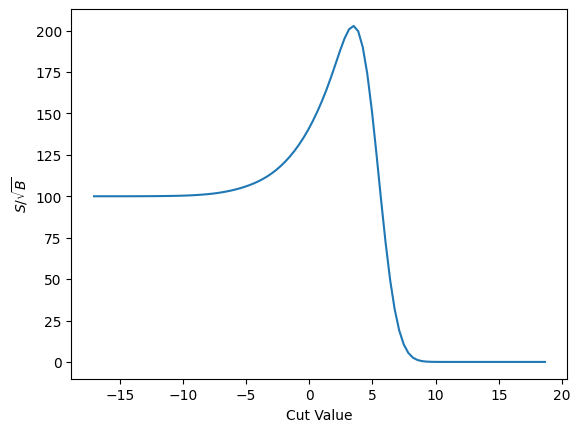

In [8]:
def plot_loss(f: Callable, metric: Callable, name: str):
    plt.plot(x_values, np.array([metric(ft.partial(f, c), data_sig_j, data_back_j) for c in x_values]))
    plt.xlabel('Cut Value')
    plt.ylabel(name)
    plt.show()

plot_loss(cut_erf, loss_sig_sqrt_b, r'$S/\sqrt{B}$')

And finally the gradient of that.

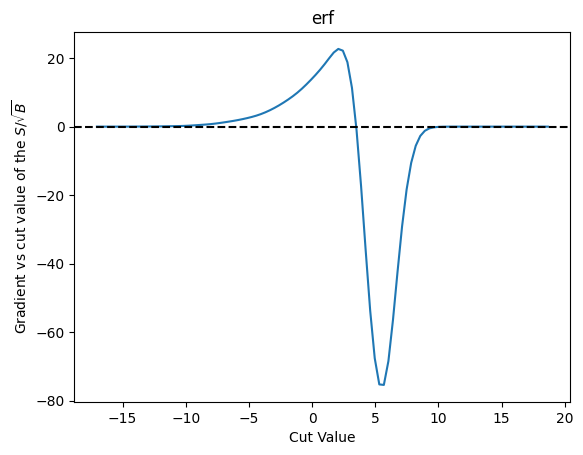

Cut Value,Gradient
-17.0294,1.26034e-06
-16.669,9.04523e-06
-16.3085,5.07146e-05
-15.9481,0.000223244
-15.5877,0.000777305
17.2099,-4.99837e-29
17.5703,-2.58265e-31
17.9308,-1.15567e-33
18.2912,-4.43999e-36
18.6516,-0


In [9]:
def plot_grad(f: Callable, f_metric: Callable, cut_name: str, metric: str):
    def calc_by_c(c):
        return f_metric(ft.partial(f, c), data_sig_j, data_back_j)

    g = jax.grad(calc_by_c)

    plt.plot(x_values, np.array([g(c) for c in x_values]))
    plt.xlabel('Cut Value')
    plt.ylabel(f'Gradient vs cut value of the {metric}')
    plt.title(cut_name)

    # And show a line where the zero is
    plt.axhline(0.0, color='black', linestyle='dashed')

    plt.show()

    # Finally, print out the last 5 and the first 5 items
    x_values_ends = list(x_values[0:5]) + list(x_values[-5:])
    g_values = [[c, float(g(c))] for c in x_values_ends]
    return tabulate.tabulate(g_values, headers=['Cut Value', 'Gradient'], tablefmt='html')

plot_grad(cut_erf, loss_sig_sqrt_b, 'erf', r'$S/\sqrt{B}$')

The fact that things are exactly zero out beyond our cuts can be seen as a real problem here - it means if a minimization starts too far to the left or right then it will not have gradient value to push it towards where it might actually alter things.

Next, lets look at the same thing for binary cross entropy. We'll code this up here ourselves (though we'll use standard utilities in libraries during training).

Note that we've had to resort to adding in the $1.0 \times 10^{-6}$. This is because the cut gets too close to zero and causes the `log` to go to infinity without it.

In [10]:
%%write_and_run -a jax_cuts.py


def loss_x_entropy(f, sig_j, back_j):
    '''Binary x-entropy for this function

    Args:
        f (Callable): The function that will calculate the prop of sig/back
        sig_j (array): Signal values
        back_j (array): Background values
    '''
    entropy_sig = -jnp.log(f(sig_j) + 1e-6)
    entropy_back = -jnp.log(1-f(back_j) + 1e-6)
    return jnp.sum(entropy_sig) + jnp.sum(entropy_back)

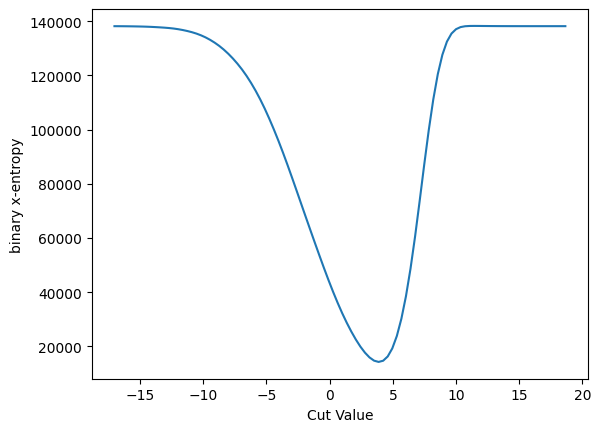

In [11]:
plot_loss(cut_erf, loss_x_entropy, 'binary x-entropy')

And the gradient:

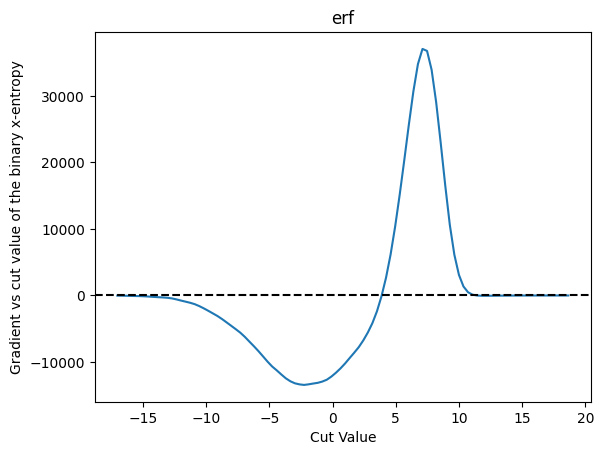

Cut Value,Gradient
-17.0294,-17.7731
-16.669,-28.0582
-16.3085,-42.4429
-15.9481,-61.5322
-15.5877,-78.1677
17.2099,-0.0414378
17.5703,-0.0103967
17.9308,-0.00204708
18.2912,-0.000314067
18.6516,-3.7412e-05


In [12]:
plot_grad(cut_erf, loss_x_entropy, 'erf', r'binary x-entropy')

This cannot be a good thing - the rise above zero at about 5 means that if we are sitting above 10 there will be false local minimum - and the cut would be driven away from that location. This is not a good behavior for ML training, I would guess.

And lets to the same for the squares difference.

In [13]:
%%write_and_run -a jax_cuts.py


def loss_squares(f: Callable, sig_j, back_j):
    '''Calculate the loss which is the sum of the squares of the difference.

    Args:
        f (Callable): Cut we are to measure the loss against
        sig_j (array): Signal data
        back_j (array): Background Data
    '''
    return jnp.sum(jnp.square((1-f(sig_j)))) + jnp.sum(jnp.square(f(back_j)))

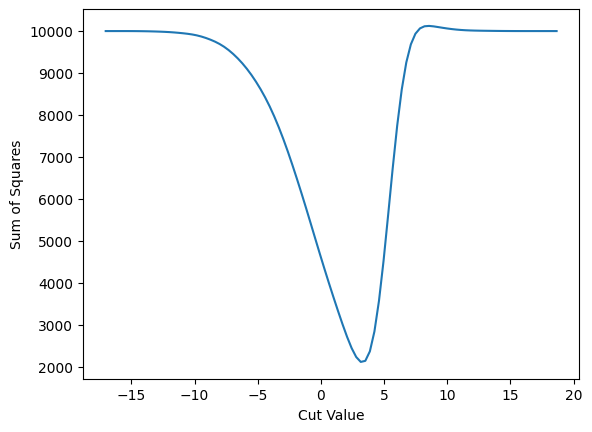

In [14]:
plot_loss(cut_erf, loss_squares, 'Sum of Squares')

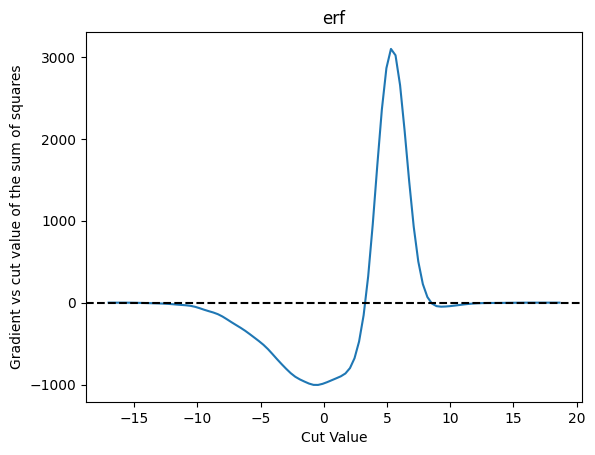

Cut Value,Gradient
-17.0294,-0.000504125
-16.669,-0.00361745
-16.3085,-0.0202648
-15.9481,-0.0888767
-15.5877,-0.305704
17.2099,-0.000659615
17.5703,-3.87915e-05
17.9308,-1.39066e-06
18.2912,-3.01843e-08
18.6516,-4.00399e-10


In [15]:
plot_grad(cut_erf, loss_squares, 'erf', 'sum of squares')

(sigmoid-intro)=
## Sigmoid Function

I discovered this approach while looking at [`gradhep`](https://github.com/gradhep)'s [`relaxed` repo](https://github.com/gradhep/relaxed) - where for a [cut they use an exponential](https://github.com/gradhep/relaxed/blob/8654d8fa64e22a3da5efc3870a855e0d26b88e9a/src/relaxed/ops.py#L16).

In [16]:
%%write_and_run -a jax_cuts.py


def cut_sigmoid(cut: float, data):
    slope = 1.0
    return 1 / (1 + jnp.exp(-slope * (data - cut)))

Now we make the basic info plots for the average weight and the $S/\sqrt{B}$.

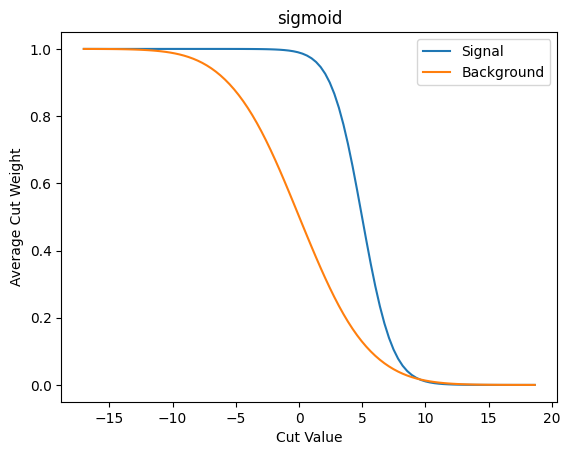

In [17]:
plot_avg_weight(cut_sigmoid, 'sigmoid')

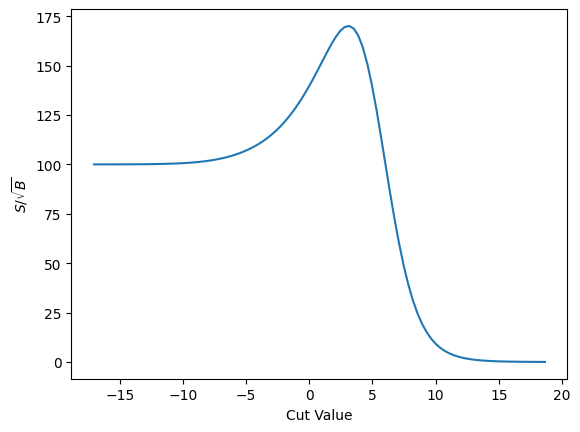

In [18]:
plot_loss(cut_sigmoid, loss_sig_sqrt_b, r'$S/\sqrt{B}$')

And finally the gradient

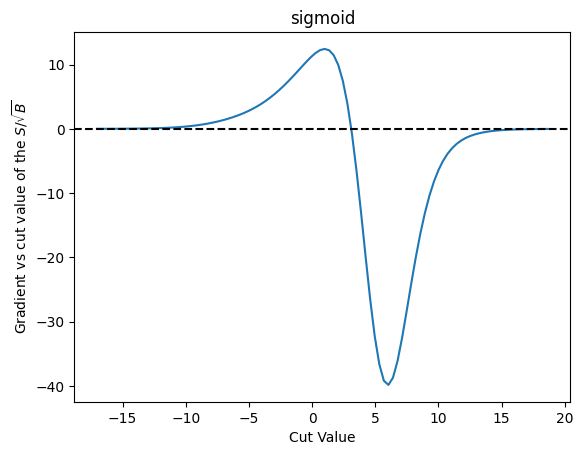

Cut Value,Gradient
-17.0294,0.00258652
-16.669,0.00365033
-16.3085,0.00512057
-15.9481,0.00712623
-15.5877,0.00981836
17.2099,-0.0498758
17.5703,-0.0406046
17.9308,-0.0332585
18.2912,-0.0273771
18.6516,-0.0226232


In [19]:
plot_grad(cut_sigmoid, loss_sig_sqrt_b, 'sigmoid', r'$S/\sqrt{B}$')

As we can see this approach suffers from similar problems. That said, it does behave more nicely than the error function I've been using up to now - and it takes longer before it trails off to "zero" here.

And we can do the same thing for binary cross entropy, and plot the gradient as well. They both have similar characteristics.

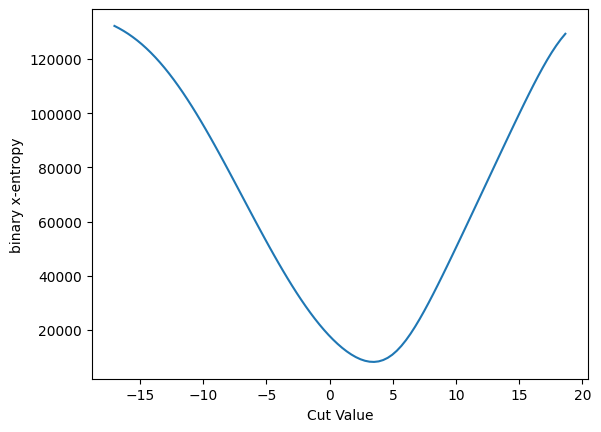

In [20]:
plot_loss(cut_sigmoid, loss_x_entropy, 'binary x-entropy')

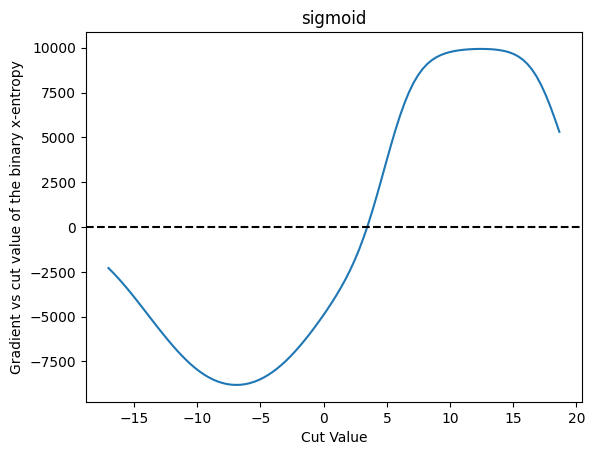

Cut Value,Gradient
-17.0294,-2288.73
-16.669,-2543.81
-16.3085,-2814.76
-15.9481,-3100.17
-15.5877,-3397.06
17.2099,7925.23
17.5703,7369.61
17.9308,6736.83
18.2912,6042.33
18.6516,5308.73


In [21]:
plot_grad(cut_sigmoid, loss_x_entropy, 'sigmoid', 'binary x-entropy')

And for the sum of the squares for comparison:

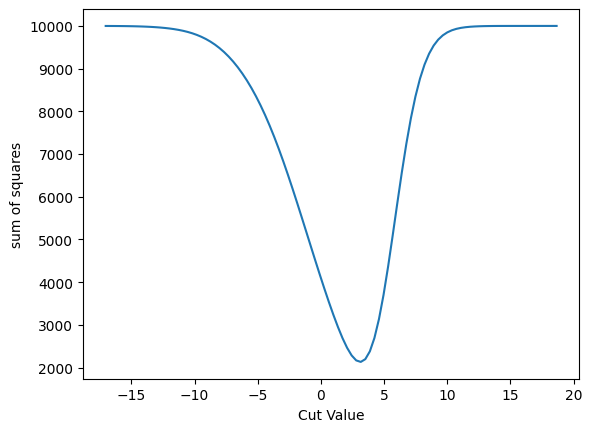

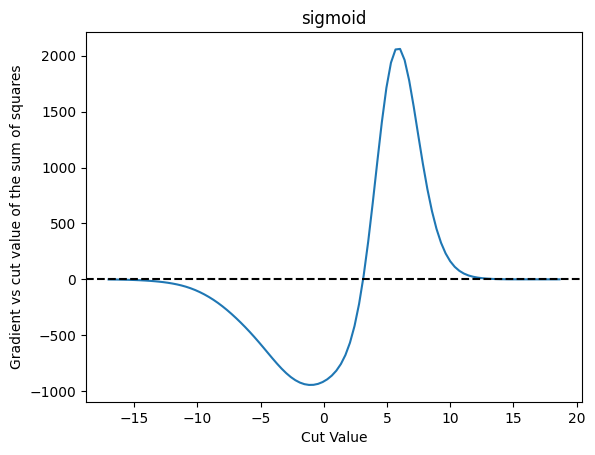

Cut Value,Gradient
-17.0294,-1.01523
-16.669,-1.42214
-16.3085,-1.97507
-15.9481,-2.71298
-15.5877,-3.67674
17.2099,0.0795874
17.5703,0.0679395
17.9308,0.054826
18.2912,0.0424349
18.6516,0.0318627


In [22]:
plot_loss(cut_sigmoid, loss_squares, 'sum of squares')
plot_grad(cut_sigmoid, loss_squares, 'sigmoid', 'sum of squares')

(sigmoid-balanced-intro)=
# Sigmoid Function - Balanced

[Studies from trying to train the cuts and NN](sigmoid-bad-loss) indicate a cut that goes zero to 1 isn't effective for classification. That indicates that we should use something that can take values negative instead. Lets design a `sigmoid` that does that.

In [23]:
%%write_and_run -a jax_cuts.py


def cut_sigmoid_balanced(cut: float, data):
    slope = 1.0
    s = 1 / (1 + jnp.exp(-slope * (data - cut)))
    return s*2.0 - 1.0

Make the basic set of plots showing how this works

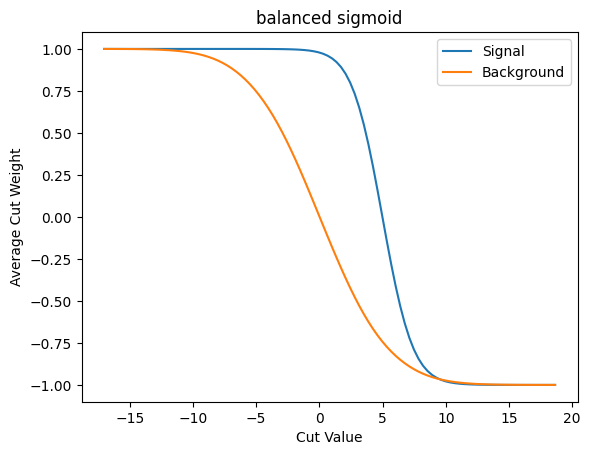

In [24]:
plot_avg_weight(cut_sigmoid_balanced, 'balanced sigmoid')

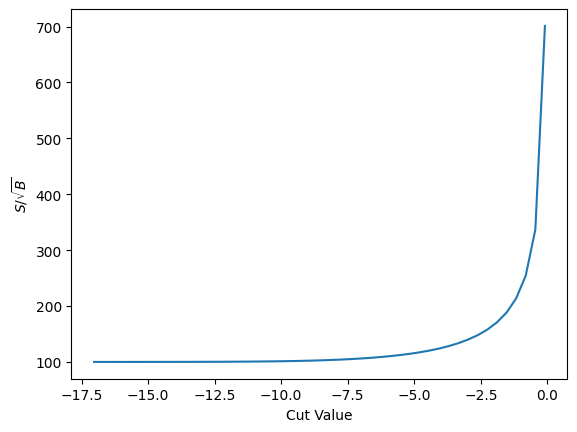

In [25]:
plot_loss(cut_sigmoid_balanced, loss_sig_sqrt_b, r'$S/\sqrt{B}$')

And the gradient:

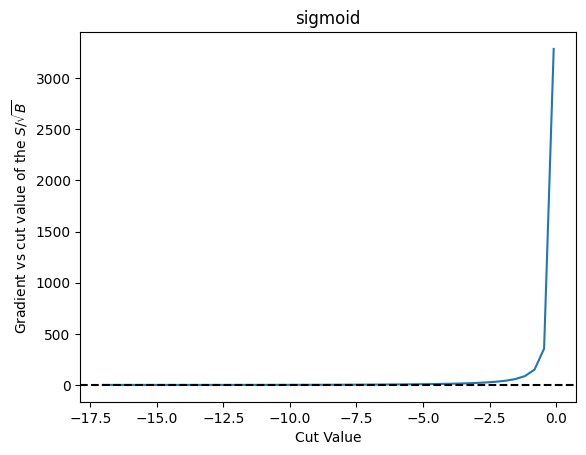

Cut Value,Gradient
-17.0294,0.00517344
-16.669,0.00730148
-16.3085,0.0102428
-15.9481,0.0142557
-15.5877,0.0196429
17.2099,nan
17.5703,nan
17.9308,nan
18.2912,nan
18.6516,nan


In [26]:
plot_grad(cut_sigmoid_balanced, loss_sig_sqrt_b, 'sigmoid', r'$S/\sqrt{B}$')

And binary x-entropy:

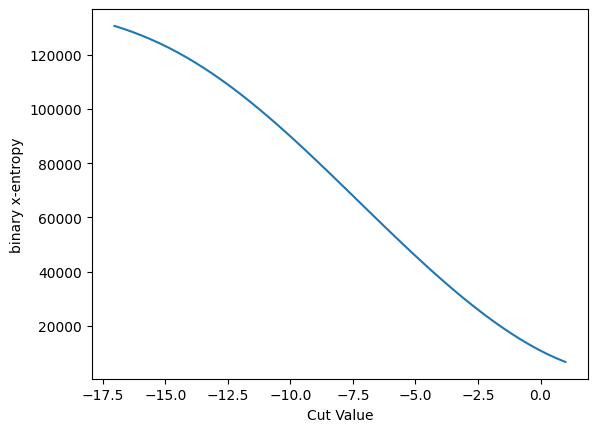

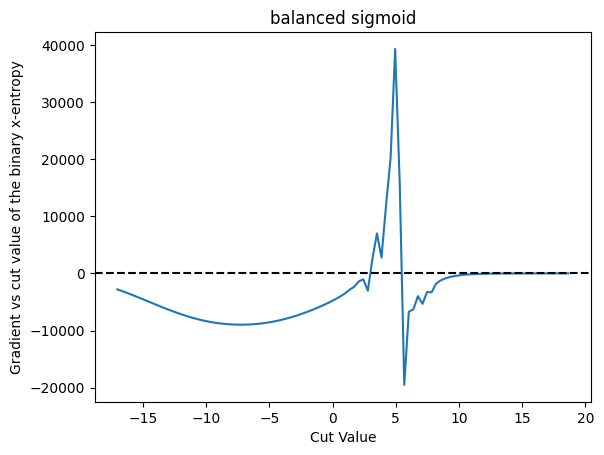

Cut Value,Gradient
-17.0294,-2797.66
-16.669,-3081.33
-16.3085,-3378.46
-15.9481,-3687.46
-15.5877,-4002.64
17.2099,-0.889872
17.5703,-0.630647
17.9308,-0.445028
18.2912,-0.313021
18.6516,-0.219637


In [27]:
plot_loss(cut_sigmoid_balanced, loss_x_entropy, 'binary x-entropy')
plot_grad(cut_sigmoid_balanced, loss_x_entropy, 'balanced sigmoid', 'binary x-entropy')

And the sum of the squares for comparison:

In [28]:
plot_loss(cut_sigmoid_balenced, loss_squares, 'sum of squares')
plot_grad(cut_sigmoid_balenced, loss_squares, 'sigmoid', 'sum of squares')

NameError: name 'cut_sigmoid_balenced' is not defined

## Comparison

A more direct comparison of some of the plots. Note the peaks occur a very slightly different places.

In [ ]:
def plot_s_sqrt_b_multi(funcs: Dict[str, Callable], metric: str, f_metric: Callable):
    for name, f in funcs.items():
        plt.plot(x_values, np.array([f_metric(ft.partial(f, c), data_sig_j, data_back_j) for c in x_values]), label=name)
    plt.xlabel('Cut Value')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

plot_s_sqrt_b_multi({'erf': cut_erf, 'sigmoid': cut_sigmoid}, r'$S/\sqrt{B}$', loss_sig_sqrt_b)
plot_s_sqrt_b_multi({'erf': cut_erf, 'sigmoid': cut_sigmoid}, 'binary x-entropy', loss_x_entropy)
plot_s_sqrt_b_multi({'erf': cut_erf, 'sigmoid': cut_sigmoid}, 'sum of squares', loss_squares)

You can see the differences better here where the derivatives are zero. This will, of course, have some implication for physics.

In [ ]:
def plot_grad_multi(funcs: Dict[str, Callable], metric: str, f_metric: Callable):
    for name, f in funcs.items():
        def calc_by_c(c):
            return f_metric(ft.partial(f, c), data_sig_j, data_back_j)

        g = jax.grad(calc_by_c)

        plt.plot(x_values, np.array([g(c) for c in x_values]), label=name)

    plt.xlabel('Cut Value')
    plt.ylabel(f'Gradient vs cut value of the {metric}')

    # And show a line where the zero is
    plt.axhline(0.0, color='black', linestyle='dashed')

    plt.legend()
    plt.show()

plot_grad_multi({'erf': cut_erf, 'sigmoid': cut_sigmoid}, r'$S/\sqrt{B}$', loss_sig_sqrt_b)
plot_grad_multi({'erf': cut_erf, 'sigmoid': cut_sigmoid}, 'binary x-entropy', loss_x_entropy)
plot_grad_multi({'erf': cut_erf, 'sigmoid': cut_sigmoid}, 'sum of squares', loss_squares)

Off these three, the binary x-entropy with the sigmoid seems to be the best behaved - we don't get into those situations where the derivative is zero. However, this may also be because it is so broad - and you might want to make it more narrow - and that will affect, of course, the accuracy of the result.